In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tqdm.notebook import tqdm

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, MSE

from tensorflow.keras.datasets.mnist import load_data

In [ ]:
(x_train, y_train), (x_test, y_test)  = load_data()

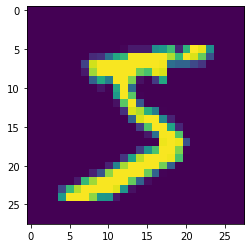

In [ ]:
plt.imshow(x_train[0])

In [ ]:
width = 128

(0, 25)


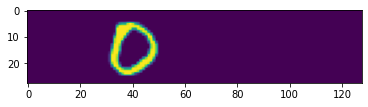

In [ ]:
def create_img(x_array, y_array, width):
    height = x_array.shape[1]
    old_width = x_array.shape[2]
    new_img = np.zeros([height, width])
    shift = random.randint(0, width-old_width)
    idx = random.randint(0, x_array.shape[0]-1)
    y = y_array[idx]
    new_img[:, shift: shift + old_width] = x_array[idx]
    return new_img, (y, shift)

_=create_img(x_train, y_train, width)
plt.imshow(_[0])
print(_[1])

In [ ]:
def make_data(x_array, y_array, scope, width):
  imgs = []
  nums = []
  shifts = []
  height = x_array.shape[1]
  for _ in tqdm(range(scope)):
    img, (num, shift) = create_img(x_array, y_array, width)
    imgs.append(img.reshape(height, width, 1))
    nums.append(num)
    shifts.append(shift)
  imgs = np.array(imgs)
  shifts = np.array(shifts).reshape(-1,1)
  nums = np.array(nums).reshape(-1,1)
  imgs = imgs/255
  return imgs, nums, shifts

In [ ]:
imgs, nums, shifts = make_data(x_train, y_train, 50000, width)

In [ ]:
inp = Input([28,128,1])

x = Conv2D(4, kernel_size=(3,3), padding="same", activation="relu")(inp)
x = MaxPool2D()(x)

x = Conv2D(8, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Flatten()(x)

x = Dense(128, activation="relu")(x)
clfs = Dense(10, activation="softmax", name="clfs")(x)
reg = Dense(1, activation="linear", name="reg")(x)

model = Model(inputs=inp, outputs=[clfs, reg])
model1 = Model(inputs=inp, outputs=[clfs, reg])

In [ ]:
model.summary()

In [ ]:
opt = Adam()

In [ ]:
def step(X, y):
    # keep track of our gradients
    with tf.GradientTape() as tape:
    # make a prediction using the model and then calculate the
    # loss
        pred = model(X)
        loss_cls = sparse_categorical_crossentropy(y[0], pred[0], from_logits=True)
        loss_reg = MSE(y[1], pred[1])
    #calculate the gradients using our tape and then update the
    # model weights
    grads = tape.gradient([loss_cls, loss_reg], model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return pred

In [ ]:
_acc = tf.keras.metrics.Accuracy()
_mae = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
ds = tf.data.Dataset.from_tensor_slices((imgs, nums, shifts)).shuffle(buffer_size=150).batch(128)

In [ ]:
for epoch in range(10):
    for xx, yy, zz in tqdm(ds):
        outs = step(xx, [yy, zz])

        res1 = _acc.update_state(yy, np.argmax(outs[0], axis=1))
        res2 = _mae.update_state(zz, outs[1])

    print("epoch: {}, reg_mae: {:5.2f}, cls_acc: {:5.2f}".format(epoch+1, _mae.result(), _acc.result()))

    _acc.reset_states()
    _mae.reset_states()


epoch: 1, reg_mae:  7.72, cls_acc:  0.16



epoch: 2, reg_mae:  2.45, cls_acc:  0.31



epoch: 3, reg_mae:  1.46, cls_acc:  0.45



epoch: 4, reg_mae:  1.05, cls_acc:  0.54



epoch: 5, reg_mae:  0.84, cls_acc:  0.59



epoch: 6, reg_mae:  0.73, cls_acc:  0.64



epoch: 7, reg_mae:  0.66, cls_acc:  0.67



epoch: 8, reg_mae:  0.60, cls_acc:  0.70



epoch: 9, reg_mae:  0.59, cls_acc:  0.73



epoch: 10, reg_mae:  0.54, cls_acc:  0.75


In [ ]:
model.compile(loss=None,
              metrics=['accuracy', "MAE"])

In [ ]:
batch_size = 128

for epoch in range(10):
    for batch in tqdm(range(0, int(len(imgs)/batch_size))):
        step(imgs[batch * batch_size: (batch + 1) * batch_size],
            [nums[batch * batch_size: (batch + 1) * batch_size],
             shifts[batch * batch_size: (batch + 1) * batch_size]])
    print(model.evaluate(imgs[:10000], [nums[:10000], shifts[:10000]]))
    

In [ ]:
model1.compile(loss=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "MSE"],
             optimizer="adam",
             metrics=["accuracy", "mae"])

In [ ]:
model1.fit(imgs, (nums, shifts), epochs=10, batch_size=128)

Epoch 1/10
391/391 [==============================] - 59s 151ms/step - loss: 1.1347 - clfs_loss: 0.7170 - reg_loss: 0.4177 - clfs_accuracy: 0.7861 - clfs_mae: 4.3761 - reg_accuracy: 0.0135 - reg_mae: 0.4823
Epoch 2/10
391/391 [==============================] - 59s 152ms/step - loss: 1.0561 - clfs_loss: 0.6617 - reg_loss: 0.3944 - clfs_accuracy: 0.8049 - clfs_mae: 4.3761 - reg_accuracy: 0.0137 - reg_mae: 0.4721
Epoch 3/10
391/391 [==============================] - 59s 152ms/step - loss: 0.9671 - clfs_loss: 0.5860 - reg_loss: 0.3810 - clfs_accuracy: 0.8280 - clfs_mae: 4.3761 - reg_accuracy: 0.0139 - reg_mae: 0.4679
Epoch 4/10
391/391 [==============================] - 59s 151ms/step - loss: 0.8752 - clfs_loss: 0.5198 - reg_loss: 0.3553 - clfs_accuracy: 0.8485 - clfs_mae: 4.3761 - reg_accuracy: 0.0142 - reg_mae: 0.4552
Epoch 5/10
391/391 [==============================] - 59s 150ms/step - loss: 0.7899 - clfs_loss: 0.4616 - reg_loss: 0.3283 - clfs_accuracy: 0.8656 - clfs_mae: 4.3761 - reg_

In [ ]:
def make_sample(imgs, nums, shifts):
  idx = random.randint(0, nums.shape[0]-1)
  print('nums:', nums[idx])
  print('shifts:', shifts[idx])
  plt.imshow(imgs[idx].reshape(28,128))
  return imgs[idx].reshape(1,28,128)

In [ ]:
imgs_test, nums_test, shifts_test = make_data(x_train, y_train, 100, width)

nums: [6]
shifts: [94]


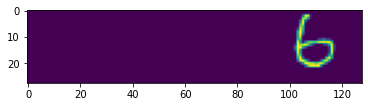

In [ ]:
f = make_sample(imgs_test, nums_test, shifts_test)

In [ ]:
model.predict(f)

[array([[1.1417558e-03, 6.2185514e-04, 7.7758357e-04, 2.4984947e-03,
         4.1617994e-04, 1.7226218e-03, 9.9244457e-01, 4.8429869e-05,
         2.9443039e-04, 3.4070377e-05]], dtype=float32),
 array([[94.21387]], dtype=float32)]

In [ ]:
model1.predict(f)

[array([[1.1417558e-03, 6.2185514e-04, 7.7758357e-04, 2.4984947e-03,
         4.1617994e-04, 1.7226218e-03, 9.9244457e-01, 4.8429869e-05,
         2.9443039e-04, 3.4070377e-05]], dtype=float32),
 array([[94.21387]], dtype=float32)]